# Pylops - sparse seismic interpolation with different thresholds

### Author: M.Ravasi

In this notebook we will compare different thresholding strategies for the ISTA and FISTA solvers for the problem of seismic interpolation. This is an attempt to reproduce the following paper ``Chen, Y., Chen, K., Shi, P., Wang, Y., “Irregular seismic data reconstruction using a percentile-half-thresholding algorithm”, Journal of Geophysics and Engineering, vol. 11. 2014.``


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.signal import convolve

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import ISTA, FISTA

alg = ISTA
#alg = FISTA

## Linear events

In [2]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':140,
       'oy':0,'dy':2,    'ny':101,
       'ot':0,'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
theta_m = [0, 30, -60]
phi_m   = [0]
amp_m   = [1., -2, 0.5]
clip = 2
kxlim = 0.05

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear2d(xaxis, taxis, v, t0_m, theta_m, amp_m, wav)

# Define available traces
perc_subsampling = 0.7
Nsub=int(np.round(par['nx']*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
#Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
#dottest(Rop, Nsub*par['nt'], par['nx']*par['nt'], verb=True)

# Create masking operator (which keeps zeros where traces are not avaiable)
mask = np.zeros(par['nx'])
mask[iava] = 1
Rop = Diagonal(mask, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop, par['nx']*par['nt'], par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
#y = y.reshape(Nsub, par['nt'])
y = y.reshape(par['nx'], par['nt'])
xadj = xadj.reshape(par['nx'], par['nt'])

# Apply mask
#ymask = Rop.mask(x.ravel())
ymask = y.copy()

snr_y = 10*np.log10(np.linalg.norm(x)**2/np.linalg.norm(ymask - x)**2)
print(snr_y)

Dot test passed, v^T(Opu)=-141.851282 - u^T(Op^Tv)=-141.851282
5.256767658761746


## Realistic data

inputfile = '../../pylops/testdata/marchenko/input.npz'
inputdata = np.load(inputfile)
clip =1e-1
kxlim = 0.01

x = inputdata['R'][50, :, :-300]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-300], inputdata['r'][0]
par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# add wavelet
wav = 0.3*inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :par['nt']]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

# Define available traces
perc_subsampling = 0.7
Nsub=int(np.round(par['nx']*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
#Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
#dottest(Rop, Nsub*par['nt'], par['nx']*par['nt'], verb=True)

# Create masking operator (which keeps zeros where traces are not avaiable)
mask = np.zeros(par['nx'])
mask[iava] = 1
Rop = Diagonal(mask, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop, par['nx']*par['nt'], par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
#y = y.reshape(Nsub, par['nt'])
y = y.reshape(par['nx'], par['nt'])
xadj = xadj.reshape(par['nx'], par['nt'])

# Apply mask
#ymask = Rop.mask(x.ravel())
ymask = y.copy()

snr_y = 10*np.log10(np.linalg.norm(x)**2/np.linalg.norm(ymask - x)**2)
print(snr_y)

### Inversion in f-k domain with sparsity-promoting solver

In [3]:
def callback(x, xtrue, prec, snr):
    if prec is not None:
        x = prec * x
    snr.append(10*np.log10(np.linalg.norm(xtrue)**2/np.linalg.norm(x - xtrue)**2))

In [4]:
# FFT of full data (use double zero padding in space axis as in paper:
# Irregularly sampled seismic data interpolation using iterative half thresholding regularization)
nffts = [2 * 2**math.ceil(math.log(par['nx'], 2)), 2**math.ceil(math.log(par['nt'], 2))]
#nffts = [2**math.ceil(math.log(par['nx'], 2)), 2**math.ceil(math.log(par['nt'], 2))]
print(nffts)

FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=nffts, sampling=[par['dx'], par['dt']])
p = FFTop*x.flatten()
p = p.reshape(nffts)

[512, 256]


In [5]:
# Common inversion params
alpha = None # finds optimal scaling for the gradient and modifies also the threshold as thresh = eps * alpha *  0.5
#alpha = 1. # enforces no scaling in the gradient and makes thresh = eps * 0.5
niter = 150

# ISTA/FISTA with hard thresholding
eps = 1e-1
snr_hard = []
pinv_hard = alg(Rop * FFTop.H, y.ravel(), niter=niter, alpha=alpha, eps=eps, threshkind='hard', show=True,
                callback=lambda i: callback(i, x.ravel(), FFTop.H, snr_hard))[0]
xinv_hard = np.real(FFTop.H * pinv_hard)
pinv_hard = pinv_hard.reshape(nffts)
xinv_hard = xinv_hard.reshape(par['nx'], par['nt'])

# ISTA/FISTA with soft thresholding
eps = 1e-1#1e-2
snr_soft = []
pinv_soft = alg(Rop * FFTop.H, y.ravel(), niter=niter, alpha=alpha, eps=eps, threshkind='soft', show=True,
                callback=lambda i: callback(i, x.ravel(), FFTop.H, snr_soft))[0]
xinv_soft = np.real(FFTop.H * pinv_soft)
pinv_soft = pinv_soft.reshape(nffts)
xinv_soft = xinv_soft.reshape(par['nx'], par['nt'])

# ISTA/FISTA with half thresholding
eps = 1e-1#5e-3
snr_half = []
pinv_half = alg(Rop * FFTop.H, y.ravel(), niter=niter, alpha=alpha, eps=eps, threshkind='half', show=True,
                callback=lambda i: callback(i, x.ravel(), FFTop.H, snr_half))[0]
xinv_half = np.real(FFTop.H * pinv_half)
pinv_half = pinv_half.reshape(nffts)
xinv_half = xinv_half.reshape(par['nx'], par['nt'])

ISTA optimization (hard thresholding)
-----------------------------------------------------------
The Operator Op has 28000 rows and 131072 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 150
alpha = 1.000000e+00	thresh = 5.000000e-02
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   9.652e+02   1.091e+03   3.696e+01
     2   0.00000e+00   1.187e+02   2.706e+02   1.022e+01
     3   0.00000e+00   5.104e+01   2.062e+02   5.970e+00
     4   0.00000e+00   3.708e+01   1.931e+02   4.206e+00
     5   0.00000e+00   3.198e+01   1.884e+02   3.153e+00
     6   0.00000e+00   2.955e+01   1.862e+02   2.468e+00
     7   0.00000e+00   2.802e+01   1.848e+02   2.085e+00
     8   0.00000e+00   2.684e+01   1.838e+02   1.806e+00
     9   0.00000e+00   2.603e+01   1.828e+02   1.741e+00
    10   0.00000e+00   2.536e+01   1.823e+02   1.425e+00
    11   0.00000e+00   2.487e+01   1.818e+02   1.225e+00
    21   0.00000e+

In [6]:
perc = 2

# ISTA/FISTA with soft-percentile thresholding
snr_hardperc = []
pinv_hardperc = alg(Rop * FFTop.H, y.ravel(), niter=niter, alpha=alpha, perc=perc, 
                    threshkind='hard-percentile', show=True,
                    callback=lambda i: callback(i, x.ravel(), FFTop.H, snr_hardperc))[0]
print(100*np.sum(pinv_hardperc!=0)/pinv_hardperc.size)
xinv_hardperc = np.real(FFTop.H * pinv_hardperc)
pinv_hardperc = pinv_hardperc.reshape(nffts)
xinv_hardperc = xinv_hardperc.reshape(par['nx'], par['nt'])

# ISTA/FISTA with soft-percentile thresholding
snr_softperc = []
pinv_softperc = alg(Rop * FFTop.H, y.ravel(), niter=niter, alpha=alpha, perc=perc, 
                    threshkind='soft-percentile', show=True,
                    callback=lambda i: callback(i, x.ravel(), FFTop.H, snr_softperc))[0]
print(100*np.sum(pinv_softperc!=0)/pinv_softperc.size)
xinv_softperc = np.real(FFTop.H * pinv_softperc)
pinv_softperc = pinv_softperc.reshape(nffts)
xinv_softperc = xinv_softperc.reshape(par['nx'], par['nt'])

# ISTA/FISTA with half-percentile thresholding
snr_halfperc = []
pinv_halfperc = alg(Rop * FFTop.H, y.ravel(), niter=niter, alpha=alpha, perc=perc, 
                    threshkind='half-percentile', show=True,
                    callback=lambda i: callback(i, x.ravel(), FFTop.H, snr_halfperc))[0]
print(100*np.sum(pinv_halfperc!=0)/pinv_halfperc.size)
xinv_halfperc = np.real(FFTop.H * pinv_halfperc)
pinv_halfperc = pinv_halfperc.reshape(nffts)
xinv_halfperc = xinv_halfperc.reshape(par['nx'], par['nt'])

ISTA optimization (hard-percentile thresholding)
-----------------------------------------------------------
The Operator Op has 28000 rows and 131072 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 150
alpha = 1.000000e+00	perc = 2.0
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   9.652e+02   1.303e+03   4.121e+01
     2   0.00000e+00   2.132e+01   3.429e+02   5.268e+00
     3   0.00000e+00   1.160e+01   3.135e+02   4.193e+00
     4   0.00000e+00   9.265e+00   2.969e+02   3.400e+00
     5   0.00000e+00   7.672e+00   2.829e+02   2.948e+00
     6   0.00000e+00   6.882e+00   2.712e+02   2.678e+00
     7   0.00000e+00   6.435e+00   2.624e+02   2.298e+00
     8   0.00000e+00   5.954e+00   2.541e+02   2.145e+00
     9   0.00000e+00   5.683e+00   2.472e+02   1.987e+00
    10   0.00000e+00   5.467e+00   2.415e+02   1.794e+00
    11   0.00000e+00   5.248e+00   2.366e+02   1.618e+00
    21   0.00000e+

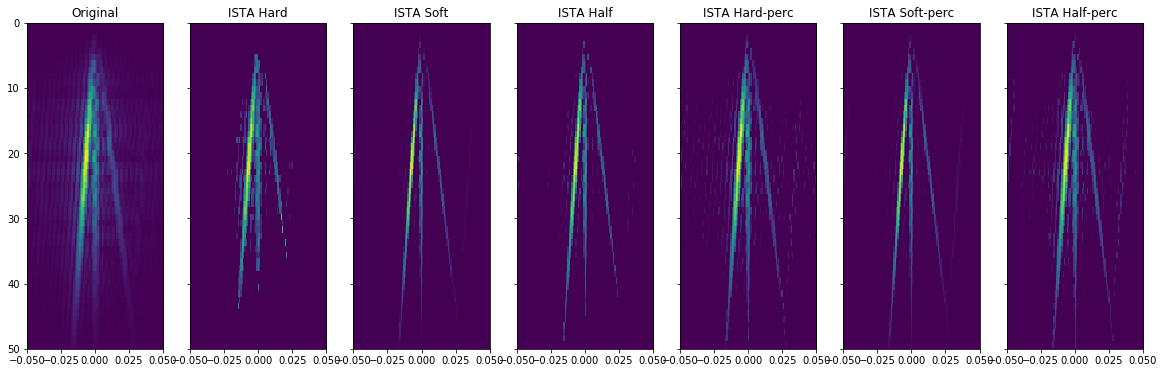

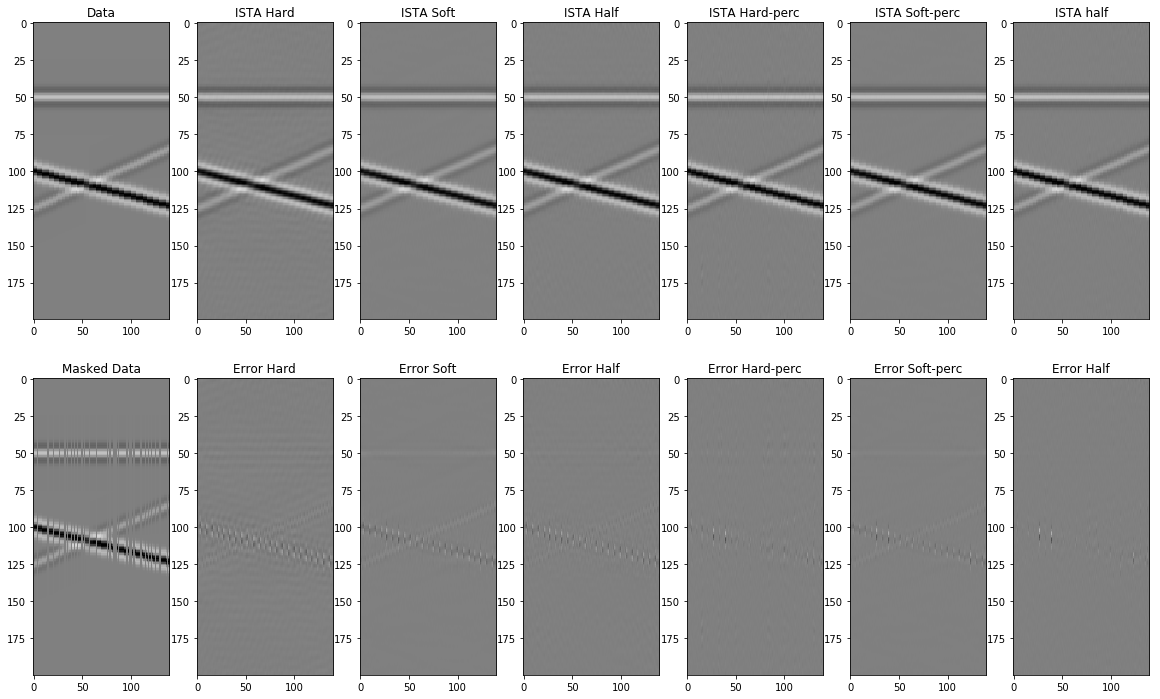

In [7]:
fig, axs = plt.subplots(1, 7, sharey=True, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nffts[1]//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[0].set_title('Original')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-kxlim, kxlim)
axs[1].imshow(np.fft.fftshift(np.abs(pinv_hard[:, :nffts[1]//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[1].set_title('ISTA Hard')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-kxlim, kxlim)
axs[2].imshow(np.fft.fftshift(np.abs(pinv_soft[:, :nffts[1]//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[2].set_title('ISTA Soft')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[2].set_xlim(-kxlim, kxlim)
axs[3].imshow(np.fft.fftshift(np.abs(pinv_half[:, :nffts[1]//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[3].set_title('ISTA Half')
axs[3].axis('tight')
axs[3].set_ylim(50, 0)
axs[3].set_xlim(-kxlim, kxlim)
axs[4].imshow(np.fft.fftshift(np.abs(pinv_hardperc[:, :nffts[1]//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[4].set_title('ISTA Hard-perc')
axs[4].axis('tight')
axs[4].set_ylim(50, 0)
axs[4].set_xlim(-kxlim, kxlim)
axs[5].imshow(np.fft.fftshift(np.abs(pinv_softperc[:, :nffts[1]//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[5].set_title('ISTA Soft-perc')
axs[5].axis('tight')
axs[5].set_ylim(50, 0)
axs[5].set_xlim(-kxlim, kxlim)
axs[6].imshow(np.fft.fftshift(np.abs(pinv_halfperc[:, :nffts[1]//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nffts[1]//2-1], FFTop.f2[0]))
axs[6].set_title('ISTA Half-perc')
axs[6].axis('tight')
axs[6].set_ylim(50, 0)
axs[6].set_xlim(-kxlim, kxlim)

fig, axs = plt.subplots(2, 7, figsize=(20, 12))
axs[0][0].imshow(x.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[1][0].imshow(ymask.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1][0].set_title('Masked Data')
axs[1][0].axis('tight')
axs[0][1].imshow(xinv_hard.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0][1].set_title('ISTA Hard')
axs[0][1].axis('tight')
axs[1][1].imshow(x.T-xinv_hard.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1][1].set_title('Error Hard')
axs[1][1].axis('tight')
axs[0][2].imshow(xinv_soft.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0][2].set_title('ISTA Soft')
axs[0][2].axis('tight')
axs[1][2].imshow(x.T-xinv_soft.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1][2].set_title('Error Soft')
axs[1][2].axis('tight')
axs[0][3].imshow(xinv_half.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0][3].set_title('ISTA Half')
axs[0][3].axis('tight');
axs[1][3].imshow(x.T-xinv_half.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1][3].set_title('Error Half')
axs[1][3].axis('tight')
axs[0][4].imshow(xinv_hardperc.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0][4].set_title('ISTA Hard-perc')
axs[0][4].axis('tight');
axs[1][4].imshow(x.T-xinv_hardperc.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1][4].set_title('Error Hard-perc')
axs[1][4].axis('tight')
axs[0][5].imshow(xinv_softperc.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0][5].set_title('ISTA Soft-perc')
axs[0][5].axis('tight');
axs[1][5].imshow(x.T-xinv_softperc.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1][5].set_title('Error Soft-perc')
axs[1][5].axis('tight')
axs[0][6].imshow(xinv_halfperc.T, cmap='gray', vmin=-clip, vmax=clip)
axs[0][6].set_title('ISTA Half-perc')
axs[0][6].axis('tight');
axs[1][6].imshow(x.T-xinv_halfperc.T, cmap='gray', vmin=-clip, vmax=clip)
axs[1][6].set_title('Error Half-perc')
axs[1][6].axis('tight');

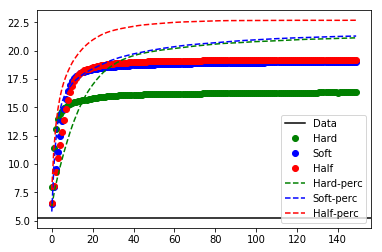

In [8]:
plt.figure()
plt.axhline(snr_y, color='k', label='Data')
plt.plot(snr_hard, 'og', label='Hard')
plt.plot(snr_soft, 'ob', label='Soft')
plt.plot(snr_half, 'or', label='Half')
plt.plot(snr_hardperc, '--g', label='Hard-perc')
plt.plot(snr_softperc, '--b', label='Soft-perc')
plt.plot(snr_halfperc, '--r', label='Half-perc')
plt.legend();